In [115]:
import re
import pandas as pd
import numpy as np
import json
import string
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [116]:
data = pd.read_csv('dataset-mei.csv', delimiter=';')

with open('stopwords.json', 'r') as file:
    stopwords_arr = json.load(file)
df_slang = pd.read_csv('kamus.csv', delimiter=';')
df_lexicon = pd.read_csv('lexicon.csv', delimiter=';')

stemmer = StemmerFactory().create_stemmer()

In [117]:
def cleaning(text):
    text = text.replace('-ness', '')
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'/n', ' ', text)
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'(?<!\bunnes)(\w)(\1+)(?=\s|[\.,!])', r'\1', text)
    text = text.strip(' ')
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = text.lower()  
    return text

def replace_word(text):
    elongated_words = re.findall(r'\b\w*(?:(\w)\1{2,})\w*\b', text)
    for word in elongated_words:
        replacement = word[0]
        text = re.sub(r'\b' + re.escape(word) + r'\b', replacement, text)
    return text

def tokenize(text):
    text = word_tokenize(text)
    return text

def translate_slang(tokens):
    translated_tokens = []
    slang_dict = df_slang.set_index('singkatan').to_dict()['kata']
    for word in tokens:
        translated_tokens.append(slang_dict.get(word, word))
    return translated_tokens

def remove_stopwords(text):
    if isinstance(text, list):  # Check if text is a list
        clean_words = []
        for sentence in text:  # Iterate through sentences in the list
            words = sentence.split()  # Split each sentence into words
            clean_sentence = [word for word in words if word.lower() not in stopwords_arr]
            clean_words.extend(clean_sentence)  # Add cleaned sentence words
        return clean_words
    else:
        words = text.split()  # Handle single string case
        clean_words = [word for word in words if word.lower() not in stopwords_arr]
        return clean_words
    
def stemming(tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

def remove_duplicates(tokens):
    unique_tokens = []
    [unique_tokens.append(token) for token in tokens if token not in unique_tokens]
    return unique_tokens

def calculate_score(tokens, df_lexicon):
    score = 0
    
    # Hitung skor berdasarkan leksikon
    for token in tokens:
        if token in df_lexicon['word'].values:
            score += df_lexicon[df_lexicon['word'] == token]['weight'].values[0]
    return score 

def sentiment(score):
    # Menentukan polaritas berdasarkan skor
    if score > 0:
        sentiment = 'positive'
    elif score < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return sentiment



In [118]:
# Kolom yang akan dihapus
columns_to_drop = [
    'conversation_id_str', 'created_at', 'favorite_count', 'id_str', 
    'image_url', 'in_reply_to_screen_name', 'lang', 'location', 
    'quote_count', 'reply_count', 'retweet_count', 'tweet_url', 
    'user_id_str', 'username'
]

# Menghapus kolom-kolom dari DataFrame
data = data.drop(columns=columns_to_drop, errors='ignore')

# Verifikasi kolom yang tersisa
print(data.columns)


Index(['full_text'], dtype='object')


In [119]:
# data = data.copy()
# data['clean_text'] = data['full_text'].apply(remove_duplicates)
# data = data.drop_duplicates(subset='clean_text')
# data

In [120]:
data['clean_text'] = data['full_text'].apply(cleaning)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,my dream university mixed feeling banget ke un...
1,Syp utbk nya di gedung arsip unnes cung aku ga...,syp utbk nya di gedung arsip unnes cung aku ga...
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,cw horor lihatlah apa yg kutemukan di unnes
3,kantin rektorat unnes malam hari https://t.co/...,kantin rektorat unnes malam hari
4,The most delicioso kebab in Unnes the one and ...,the most delicioso kebab in unnes the one and ...
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,aku bingung harus daftar kedinasan atau engga
4602,@unnesmenfess Belum buka nder,belum buka nder
4603,@unnesmenfess Qris bisa nder,qris bisa nder
4604,https://t.co/05wpAe4Zpm,


In [121]:
data['clean_text'] = data['clean_text'].apply(replace_word)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,my dream university mixed feeling banget ke un...
1,Syp utbk nya di gedung arsip unnes cung aku ga...,syp utbk nya di gedung arsip unnes cung aku ga...
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,cw horor lihatlah apa yg kutemukan di unnes
3,kantin rektorat unnes malam hari https://t.co/...,kantin rektorat unnes malam hari
4,The most delicioso kebab in Unnes the one and ...,the most delicioso kebab in unnes the one and ...
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,aku bingung harus daftar kedinasan atau engga
4602,@unnesmenfess Belum buka nder,belum buka nder
4603,@unnesmenfess Qris bisa nder,qris bisa nder
4604,https://t.co/05wpAe4Zpm,


In [122]:
data['clean_text'] = data['clean_text'].apply(tokenize)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, banget..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[syp, utbk, nya, di, gedung, arsip, unnes, cun..."
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cw, horor, lihatlah, apa, yg, kutemukan, di, ..."
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, unnes, malam, hari]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, unnes, the, ..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[aku, bingung, harus, daftar, kedinasan, atau,..."
4602,@unnesmenfess Belum buka nder,"[belum, buka, nder]"
4603,@unnesmenfess Qris bisa nder,"[qris, bisa, nder]"
4604,https://t.co/05wpAe4Zpm,[]


In [123]:
data['clean_text'] = data['clean_text'].apply(translate_slang)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, sekali..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[siapa, utbk, nya, di, gedung, arsip, unnes, c..."
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek , horor, lihatlah, apa, yang , kutemuka..."
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, unnes, malam, hari]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, unnes, the, ..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[saya, bingung, harus, daftar, kedinasan, atau..."
4602,@unnesmenfess Belum buka nder,"[belum, buka, nder]"
4603,@unnesmenfess Qris bisa nder,"[qris, bisa, nder]"
4604,https://t.co/05wpAe4Zpm,[]


In [124]:
data['clean_text'] = data['clean_text'].apply(lambda x: remove_stopwords(x))
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]"
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihatlah, kutemukan]"
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, the, one, an..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, kedinasan]"
4602,@unnesmenfess Belum buka nder,[buka]
4603,@unnesmenfess Qris bisa nder,[qris]
4604,https://t.co/05wpAe4Zpm,[]


In [125]:
data['clean_text'] = data['clean_text'].apply(stemming)
data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]"
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihat, temu]"
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, the, one, an..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, dinas]"
4602,@unnesmenfess Belum buka nder,[buka]
4603,@unnesmenfess Qris bisa nder,[qris]
4604,https://t.co/05wpAe4Zpm,[]


In [126]:
data['clean_text'] = data['clean_text'].apply(remove_duplicates)

data

,full_text,clean_text
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s..."
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]"
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihat, temu]"
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]"
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, one, and, on..."
...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, dinas]"
4602,@unnesmenfess Belum buka nder,[buka]
4603,@unnesmenfess Qris bisa nder,[qris]
4604,https://t.co/05wpAe4Zpm,[]


In [127]:
data['score'] = data['clean_text'].apply(lambda x: calculate_score(x, df_lexicon))
data

,full_text,clean_text,score
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s...",1
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]",0
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihat, temu]",-3
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]",0
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, one, and, on...",1
...,...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, dinas]",-2
4602,@unnesmenfess Belum buka nder,[buka],0
4603,@unnesmenfess Qris bisa nder,[qris],0
4604,https://t.co/05wpAe4Zpm,[],0


In [128]:
data['sentimen'] = data['score'].apply(sentiment)
data

,full_text,clean_text,score,sentimen
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s...",1,positive
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]",0,neutral
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihat, temu]",-3,negative
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]",0,neutral
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, one, and, on...",1,positive
...,...,...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, dinas]",-2,negative
4602,@unnesmenfess Belum buka nder,[buka],0,neutral
4603,@unnesmenfess Qris bisa nder,[qris],0,neutral
4604,https://t.co/05wpAe4Zpm,[],0,neutral


In [129]:
output_file = 'data.csv'
data.to_csv(output_file, sep=';', index=False)

In [130]:
data

,full_text,clean_text,score,sentimen
0,my dream university mixed feeling banget ke un...,"[my, dream, university, mixed, feeling, pas, s...",1,positive
1,Syp utbk nya di gedung arsip unnes cung aku ga...,"[utbk, gedung, arsip, cung, teman]",0,neutral
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,"[cewek, horor, lihat, temu]",-3,negative
3,kantin rektorat unnes malam hari https://t.co/...,"[kantin, rektorat, malam]",0,neutral
4,The most delicioso kebab in Unnes the one and ...,"[the, most, delicioso, kebab, in, one, and, on...",1,positive
...,...,...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,"[bingung, daftar, dinas]",-2,negative
4602,@unnesmenfess Belum buka nder,[buka],0,neutral
4603,@unnesmenfess Qris bisa nder,[qris],0,neutral
4604,https://t.co/05wpAe4Zpm,[],0,neutral


In [131]:
# Menghitung jumlah labelling positif, netral, dan negatif
jumlah_sentimen = data['sentimen'].value_counts()

# Menampilkan hasil
print(jumlah_sentimen)


sentimen
neutral     2370
positive    1239
negative     997
Name: count, dtype: int64


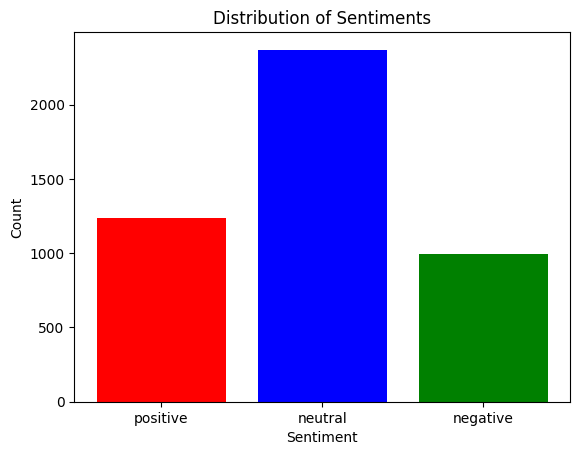

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

counts = data["sentimen"].value_counts()  
desired_order = ['positive', 'neutral', 'negative']
ordered_counts = counts.reindex(desired_order, fill_value=0)
colors = ['red', 'blue', 'green'] 
plt.bar(ordered_counts.index, ordered_counts.values, color=colors)  

plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Sentiments")
plt.show()

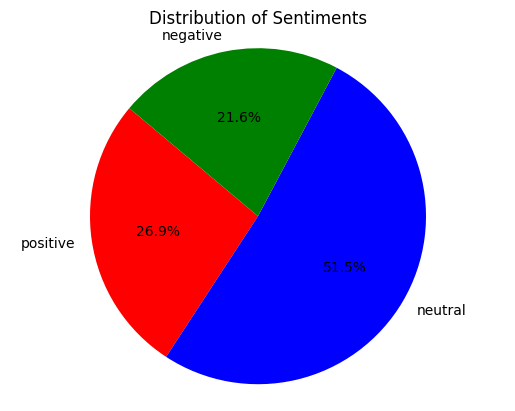

In [133]:
import pandas as pd
import matplotlib.pyplot as plt

counts = data["sentimen"].value_counts()  
desired_order = ['positive', 'neutral', 'negative']
ordered_counts = counts.reindex(desired_order, fill_value=0)
colors = ['red', 'blue', 'green'] 
plt.pie(ordered_counts, labels=ordered_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Sentiments")
plt.axis('equal')  
plt.show()


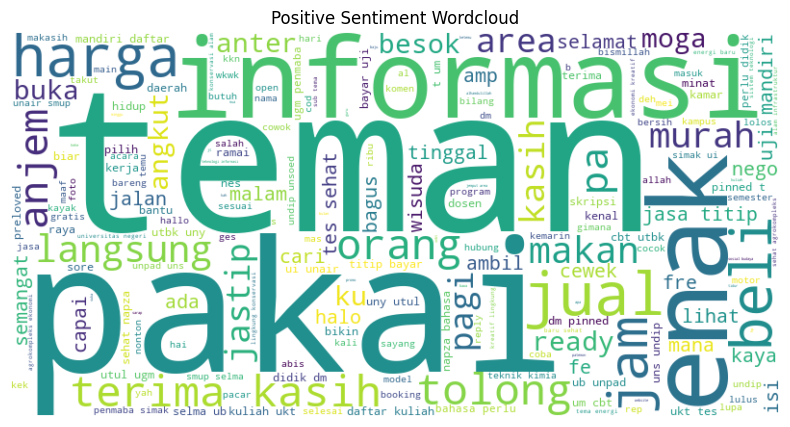

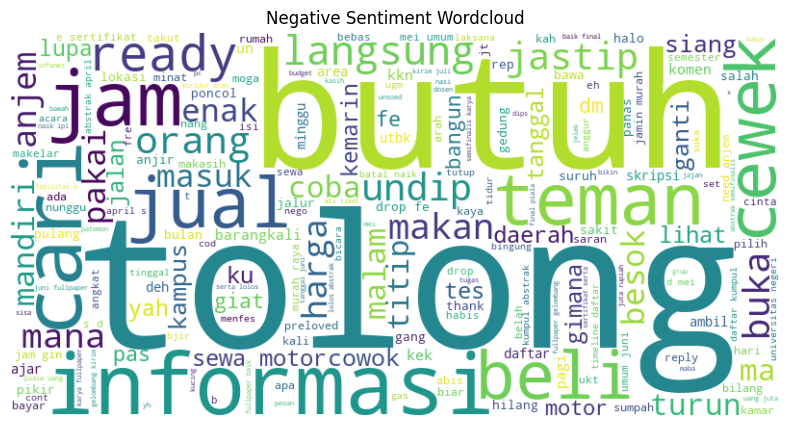

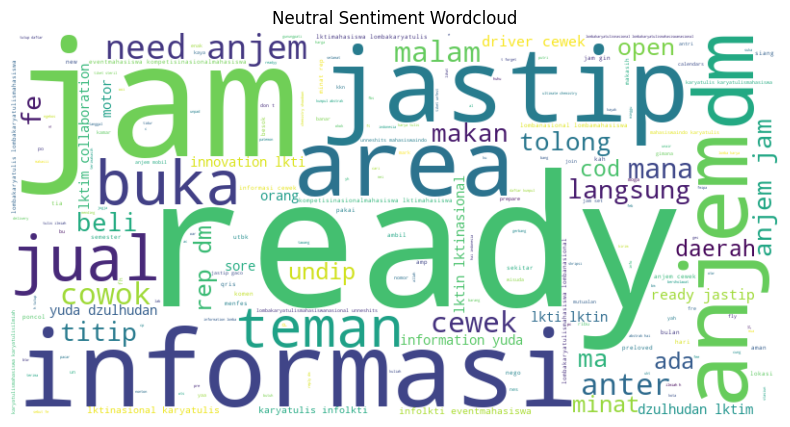

In [134]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Fungsi untuk membuat dan menampilkan wordcloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Pisahkan data berdasarkan sentimen
data_positive = data[data['sentimen'] == 'positive']
data_negative = data[data['sentimen'] == 'negative']
data_neutral = data[data['sentimen'] == 'neutral']

# Gabungkan semua token menjadi satu string untuk setiap sentimen
tokens_positive = [token for sublist in data_positive['clean_text'] for token in sublist]
text_positive = ' '.join(tokens_positive)

tokens_negative = [token for sublist in data_negative['clean_text'] for token in sublist]
text_negative = ' '.join(tokens_negative)

tokens_neutral = [token for sublist in data_neutral['clean_text'] for token in sublist]
text_neutral = ' '.join(tokens_neutral)

# Buat dan tampilkan wordcloud untuk setiap sentimen
generate_wordcloud(text_positive, 'Positive Sentiment Wordcloud')
generate_wordcloud(text_negative, 'Negative Sentiment Wordcloud')
generate_wordcloud(text_neutral, 'Neutral Sentiment Wordcloud')

In [135]:
# Gabungkan token menjadi string teks
data['clean_text'] = data['clean_text'].apply(lambda x: ' '.join(x))
data

,full_text,clean_text,score,sentimen
0,my dream university mixed feeling banget ke un...,my dream university mixed feeling pas selesai ...,1,positive
1,Syp utbk nya di gedung arsip unnes cung aku ga...,utbk gedung arsip cung teman,0,neutral
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,cewek horor lihat temu,-3,negative
3,kantin rektorat unnes malam hari https://t.co/...,kantin rektorat malam,0,neutral
4,The most delicioso kebab in Unnes the one and ...,the most delicioso kebab in one and only gaza,1,positive
...,...,...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,bingung daftar dinas,-2,negative
4602,@unnesmenfess Belum buka nder,buka,0,neutral
4603,@unnesmenfess Qris bisa nder,qris,0,neutral
4604,https://t.co/05wpAe4Zpm,,0,neutral


In [136]:
sentiment_mapping = {
    'negative': -1,
    'neutral': 0,
    'positive': 1
}
data['sentimen'] = data['sentimen'].map(sentiment_mapping)
data

,full_text,clean_text,score,sentimen
0,my dream university mixed feeling banget ke un...,my dream university mixed feeling pas selesai ...,1,1
1,Syp utbk nya di gedung arsip unnes cung aku ga...,utbk gedung arsip cung teman,0,0
2,CW//HOROR lihatlah apa yg kutemukan di unnes h...,cewek horor lihat temu,-3,-1
3,kantin rektorat unnes malam hari https://t.co/...,kantin rektorat malam,0,0
4,The most delicioso kebab in Unnes the one and ...,the most delicioso kebab in one and only gaza,1,1
...,...,...,...,...
4601,aku bingung harus daftar kedinasan atau engga....,bingung daftar dinas,-2,-1
4602,@unnesmenfess Belum buka nder,buka,0,0
4603,@unnesmenfess Qris bisa nder,qris,0,0
4604,https://t.co/05wpAe4Zpm,,0,0


In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import random

# Assuming data is already loaded
X = data['clean_text']
y = data['sentimen']

# Set random seed for reproducibility
random_seed = 20
np.random.seed(random_seed)
random.seed(random_seed)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

# TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Feature selection
selector = SelectKBest(chi2, k=1000)  
X_train_chi2 = selector.fit_transform(X_train_tfidf, y_train)
X_test_chi2 = selector.transform(X_test_tfidf)


In [138]:
pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())


,abad,abah,abal,abang,abaya,abdi,abiesst,abis,absen,abstrak,...,yutub,yuuk,zaenuri,zaki,zakiya,zhafira,zionis,zona,zonk,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
pd.DataFrame(X_train_chi2.toarray(), columns=selector.get_feature_names_out())

,x7,x8,x9,x15,x26,x29,x31,x39,x40,x43,...,x5243,x5248,x5258,x5266,x5267,x5285,x5308,x5313,x5315,x5321
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.287187,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.229245,0.000000,0.0,0.0,0.0,0.0
3680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [140]:
# Overfitting with SMOTE
smote = SMOTE(random_state=random_seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train_chi2, y_train)


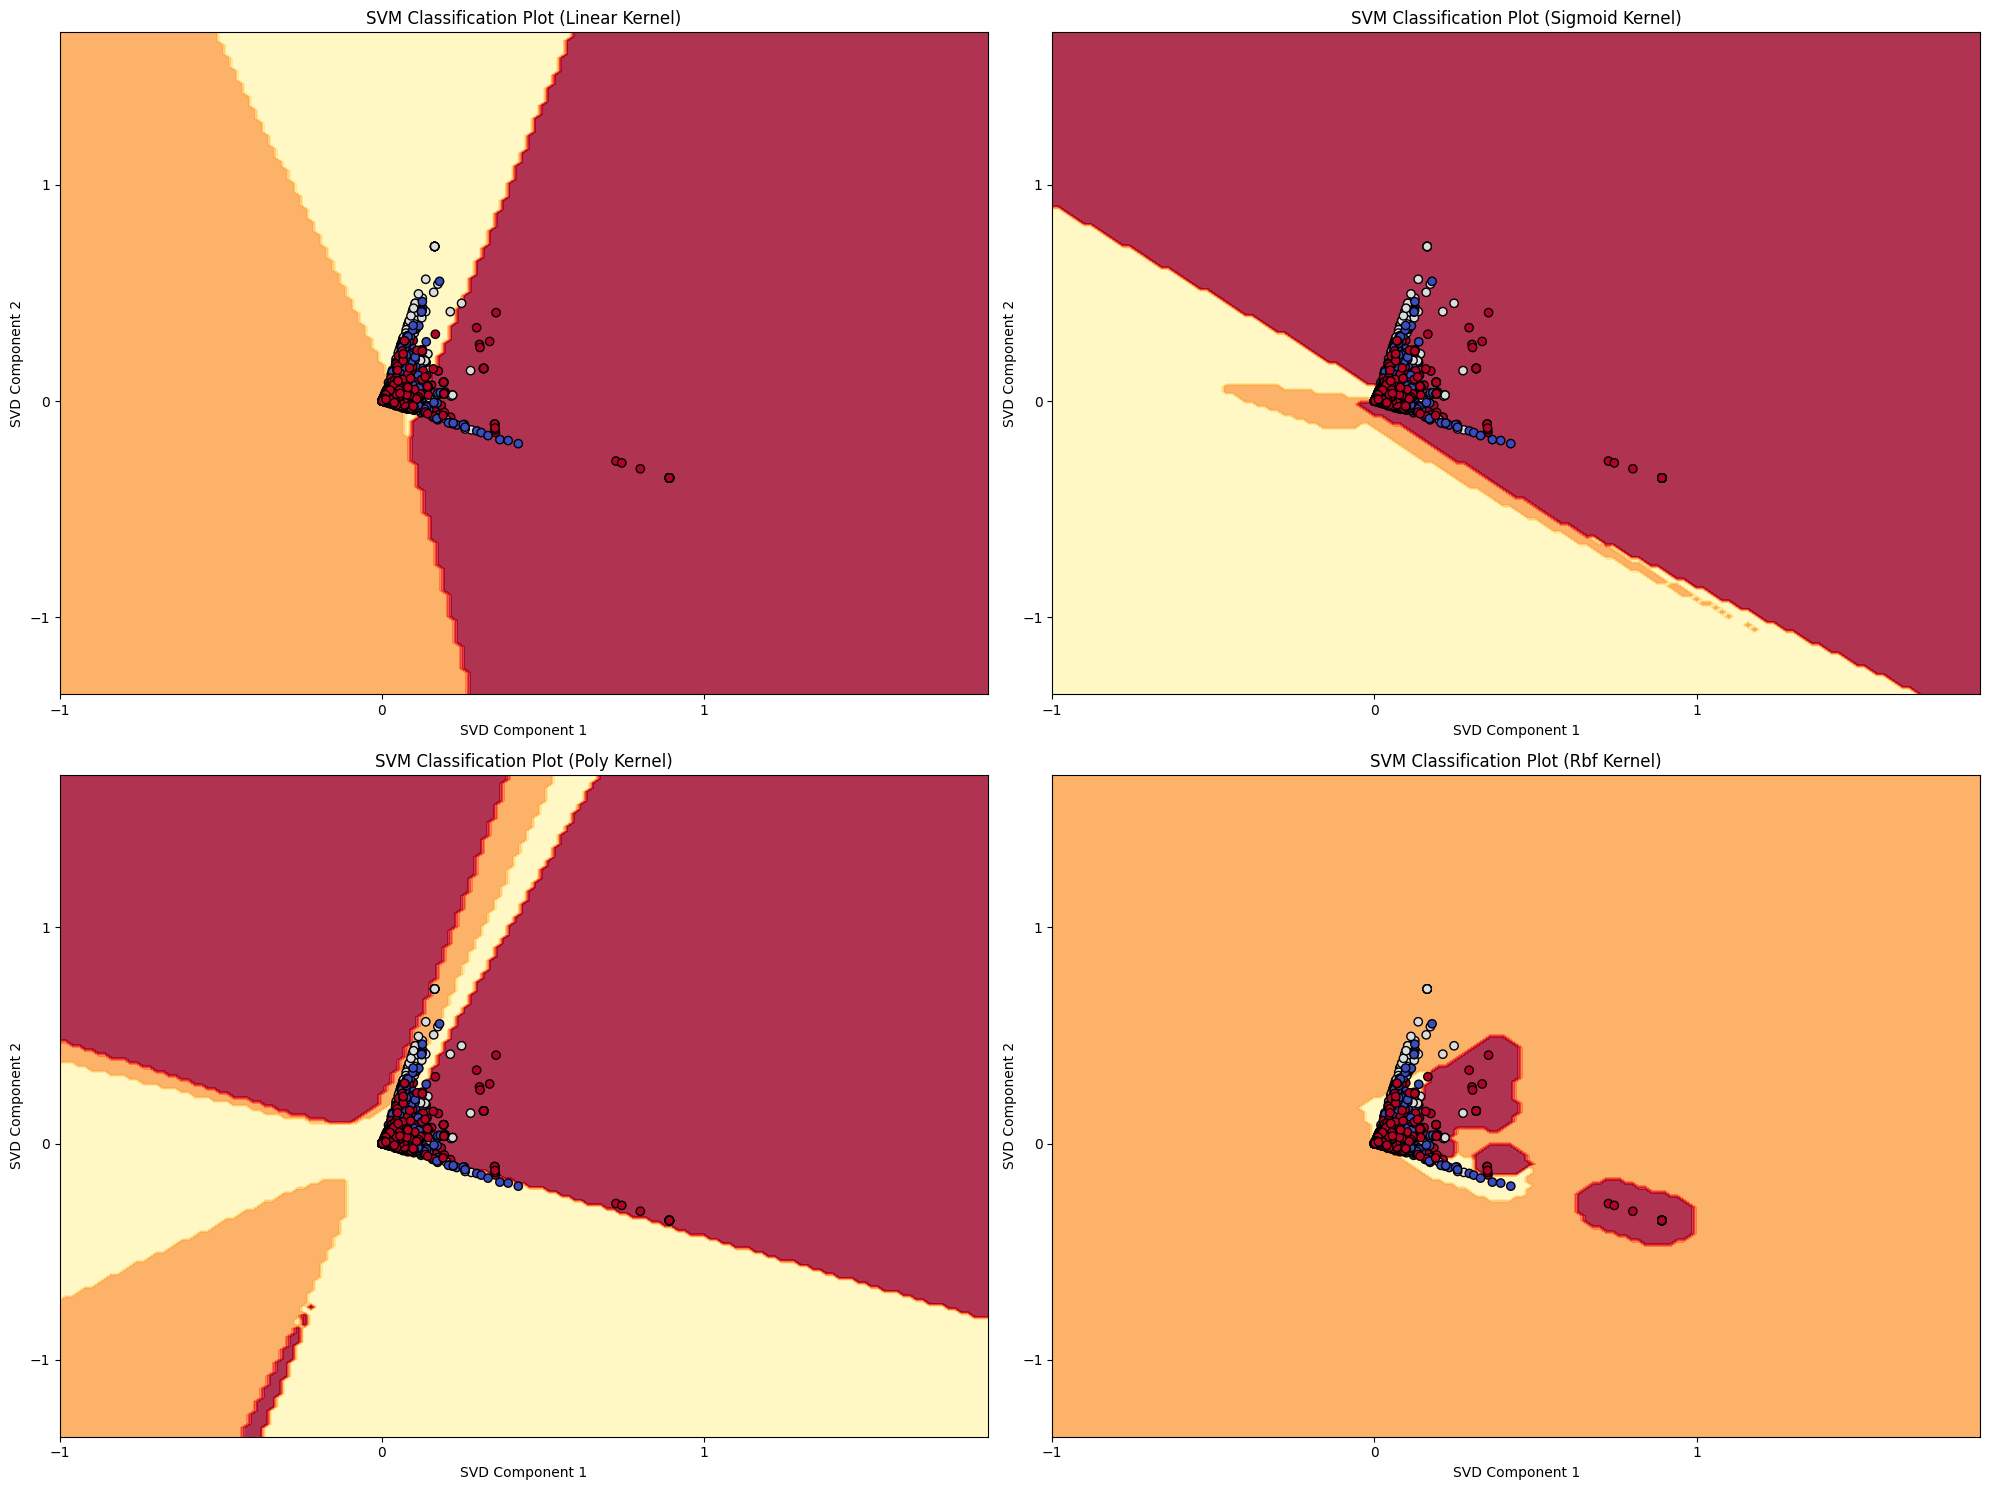

In [141]:
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

# Dimensionality reduction to 2D for visualization using TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=random_seed)
X_train_svd = svd.fit_transform(X_train_smote)
X_test_svd = svd.transform(X_test_chi2)

# Define kernels to test
kernels = ['linear', 'sigmoid', 'poly', 'rbf']

# Create a figure to hold the subplots
plt.figure(figsize=(20, 15))

for i, kernel in enumerate(kernels):
    # Train SVM classifier with the specified kernel
    svm = SVC(kernel=kernel, random_state=random_seed)
    svm.fit(X_train_svd, y_train_smote)
    
    # Create a meshgrid for visualization
    h = .02  # step size in the mesh
    x_min, x_max = X_train_svd[:, 0].min() - 1, X_train_svd[:, 0].max() + 1
    y_min, y_max = X_train_svd[:, 1].min() - 1, X_train_svd[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict using the SVM classifier
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plotting the decision boundary and data points
    plt.subplot(2, 2, i + 1)  # 2 rows, 2 columns, i+1 subplot
    plt.contourf(xx, yy, Z, cmap=plt.cm.YlOrRd, alpha=0.8)
    plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_train_smote, cmap=plt.cm.coolwarm, edgecolor='k')
    plt.xlabel('SVD Component 1')
    plt.ylabel('SVD Component 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(np.arange(int(x_min), int(x_max) + 1, 1.0))
    plt.yticks(np.arange(int(y_min), int(y_max) + 1, 1.0))
    plt.title(f'SVM Classification Plot ({kernel.capitalize()} Kernel)')

plt.tight_layout()
plt.show()


In [142]:
# Models
models = {
    'SVM (Linear Kernel)': SVC(kernel='linear', random_state=random_seed),
    'SVM (RBF Kernel)': SVC(kernel='rbf', random_state=random_seed),
    'SVM (Sigmoid Kernel)': SVC(kernel='sigmoid', random_state=random_seed),
    'SVM (Polynomial Kernel)': SVC(kernel='poly', random_state=random_seed),
}

# Train and evaluate each model
for model_name, model in models.items():
    # Train model
    model.fit(X_train_smote, y_train_smote)
    
    # Predict
    y_pred = model.predict(X_test_chi2)
    
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Print results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("-" * 60)


Model: SVM (Linear Kernel)
Accuracy: 0.7939
Classification Report:
              precision    recall  f1-score   support

          -1       0.71      0.69      0.70       200
           0       0.86      0.88      0.87       474
           1       0.74      0.72      0.73       248

    accuracy                           0.79       922
   macro avg       0.77      0.76      0.76       922
weighted avg       0.79      0.79      0.79       922

------------------------------------------------------------
Model: SVM (RBF Kernel)
Accuracy: 0.8145
Classification Report:
              precision    recall  f1-score   support

          -1       0.72      0.73      0.73       200
           0       0.93      0.85      0.89       474
           1       0.70      0.82      0.75       248

    accuracy                           0.81       922
   macro avg       0.79      0.80      0.79       922
weighted avg       0.83      0.81      0.82       922

----------------------------------------------

In [143]:
# Definisikan parameter grid
C_values = [0.1, 1]  
gamma_values = [1, 2, 3, 4, 5]

# List untuk menyimpan hasil
results = []

# Loop melalui semua kombinasi parameter
for C in C_values:
    for gamma in gamma_values:
        svm_rbf = SVC(kernel='rbf', C=C, gamma=gamma)
        svm_rbf.fit(X_train_smote, y_train_smote)
        y_pred = svm_rbf.predict(X_test_chi2)
        accuracy = accuracy_score(y_test, y_pred)
        results.append({'C': C, 'gamma': gamma, 'accuracy': accuracy * 100})

results_df = pd.DataFrame(results)
print(results_df)

top_15_results = results_df.sort_values(by='accuracy', ascending=False).head(15)
print(top_15_results)


     C  gamma   accuracy
0  0.1      1  74.295011
1  0.1      2  75.054230
2  0.1      3  73.101952
3  0.1      4  68.980477
4  0.1      5  67.353579
5  1.0      1  79.609544
6  1.0      2  81.236443
7  1.0      3  81.019523
8  1.0      4  80.694143
9  1.0      5  80.151844
     C  gamma   accuracy
6  1.0      2  81.236443
7  1.0      3  81.019523
8  1.0      4  80.694143
9  1.0      5  80.151844
5  1.0      1  79.609544
1  0.1      2  75.054230
0  0.1      1  74.295011
2  0.1      3  73.101952
3  0.1      4  68.980477
4  0.1      5  67.353579


In [147]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Training SVM classifier
svm_clf = SVC(kernel='rbf', C=1, gamma=2, random_state=random_seed)
svm_clf.fit(X_train_smote, y_train_smote)

# Predictions
y_pred = svm_clf.predict(X_test_chi2)

# Evaluation
accuracy_svm = accuracy_score(y_test, y_pred)
print("SVM Classification Report:\n", classification_report(y_test, y_pred))
print("SVM Accuracy:", accuracy_svm)
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

SVM Classification Report:
               precision    recall  f1-score   support

          -1       0.71      0.73      0.72       200
           0       0.92      0.85      0.89       474
           1       0.71      0.80      0.75       248

    accuracy                           0.81       922
   macro avg       0.78      0.80      0.79       922
weighted avg       0.82      0.81      0.82       922

SVM Accuracy: 0.8123644251626898
SVM Confusion Matrix:
 [[147  13  40]
 [ 30 404  40]
 [ 30  20 198]]


In [148]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def fitness_function(params, X_train, y_train, X_test, y_test):
    C, gamma = params
    model = SVC(C=C, gamma=gamma, kernel='rbf', random_state=random_seed)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

class Particle:
    def __init__(self, bounds):
        self.position = np.array([np.random.uniform(bound[0], bound[1]) for bound in bounds])
        self.velocity = np.random.uniform(-1, 1, len(bounds))
        self.best_position = self.position.copy()
        self.best_score = -1

def pso_optimize(fitness_function, bounds, num_particles, max_iter, X_train, y_train, X_test, y_test):
    particles = [Particle(bounds) for _ in range(num_particles)]
    global_best_position = particles[0].position.copy()
    global_best_score = -1

    for _ in range(max_iter):
        for particle in particles:
            fitness = fitness_function(particle.position, X_train, y_train, X_test, y_test)
            if fitness > particle.best_score:
                particle.best_score = fitness
                particle.best_position = particle.position.copy()
            if fitness > global_best_score:
                global_best_score = fitness
                global_best_position = particle.position.copy()
        
        for particle in particles:
            inertia_weight = 0.5
            cognitive_weight = 2
            social_weight = 2

            inertia = inertia_weight * particle.velocity
            cognitive = cognitive_weight * np.random.rand() * (particle.best_position - particle.position)
            social = social_weight * np.random.rand() * (global_best_position - particle.position)
            
            particle.velocity = inertia + cognitive + social
            particle.position += particle.velocity

            for i, bound in enumerate(bounds):
                if particle.position[i] < bound[0]:
                    particle.position[i] = bound[0]
                if particle.position[i] > bound[1]:
                    particle.position[i] = bound[1]
                    
    return global_best_position, global_best_score

# Parameter bounds: [C, gamma]
bounds = [(0.1, 10), (0.0001, 10)]

# PSO optimization
best_params, best_score = pso_optimize(fitness_function, bounds, num_particles=10, max_iter=20, 
                                       X_train=X_train_smote, y_train=y_train_smote, 
                                       X_test=X_test_chi2, y_test=y_test)

print(f"Optimal parameters: C={best_params[0]}, gamma={best_params[1]}")
print(f"Best accuracy: {best_score}")

# Train SVM with optimal parameters
optimal_svm_clf = SVC(C=best_params[0], gamma=best_params[1], kernel='rbf', random_state=random_seed)
optimal_svm_clf.fit(X_train_smote, y_train_smote)

# Predictions
optimal_y_pred = optimal_svm_clf.predict(X_test_chi2)

# Calculate accuracy
accuracy_pso = accuracy_score(y_test, optimal_y_pred)

# Evaluation
print("SVM PSO Classification Report:\n", classification_report(y_test, optimal_y_pred))
print("SVM PSO Accuracy:", accuracy_pso)
print("SVM PSO Confusion Matrix:\n", confusion_matrix(y_test, optimal_y_pred))


Optimal parameters: C=6.781206161262784, gamma=1.3838703752137216
Best accuracy: 0.8351409978308026
SVM PSO Classification Report:
               precision    recall  f1-score   support

          -1       0.78      0.72      0.75       200
           0       0.90      0.91      0.90       474
           1       0.76      0.79      0.77       248

    accuracy                           0.84       922
   macro avg       0.81      0.81      0.81       922
weighted avg       0.83      0.84      0.83       922

SVM PSO Accuracy: 0.8351409978308026
SVM PSO Confusion Matrix:
 [[145  19  36]
 [ 18 430  26]
 [ 24  29 195]]


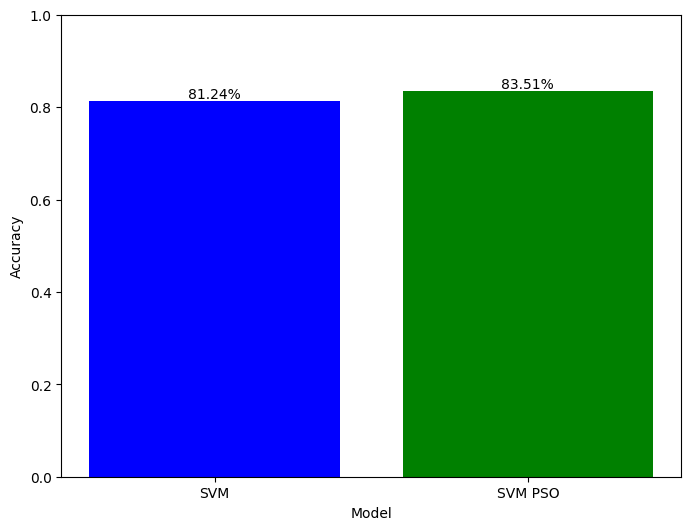

In [150]:

# Membuat diagram batang
models = ['SVM', 'SVM PSO']
accuracies = [accuracy_svm, accuracy_pso]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')


# Menambahkan nilai akurasi pada setiap batang
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy, f'{accuracy * 100:.2f}%', ha='center', va='bottom')

plt.ylim(0, 1)  # Asumsi akurasi berkisar antara 0 hingga 1
plt.grid(False)  # Menghilangkan grid
plt.show()